In this notebook, we will use the popular machine learning package for neural networks and deep learning, [Keras](https://keras.io) which is built on top of[tensorflow](https://www.tensorflow.org).   

We work with the [Handwritten Digits Data Sets](http://scikit-learn.org/stable/datasets/#optical-recognition-of-handwritten-digits-data-set) again to classify the digits using a Multilayer Perceptron (MLP). 

Note the example used here is modified by Qingkai Kong from [Keras Example](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py)

In [1]:
# import all the needed module
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


## Load and visualize data 

Just like in the last notebook, let's load the [Handwritten Digits Data Set](http://yann.lecun.com/exdb/mnist/) but from Keras this time. Once again, the dataset contains images of the 10 classes of handwritten digits (0 to 9). The data includes a training set of 60,000 examples, and a test set of 10,000 examples which is a subset of a larger set available from NIST.  

In [2]:
# load data which is already split for us as a train and test set
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 3s 0us/step


In [3]:
print(f'The dataset contains {len(x_train)} training data examples, and {len(x_test)} test data examples')

The dataset contains 60000 training data examples, and 10000 test data examples


In [4]:
# The unique classes
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of anti-aliasing (a technique to minimize distortion when compressing an image). The images were also centered in a 28x28 image by computing the center of mass of the pixels.

In [17]:
# let's look at one sample in our training data
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [9]:
# the first 10 labels/classes of the training data
print(y_train[0:10])

[5 0 4 1 9 2 1 3 1 4]


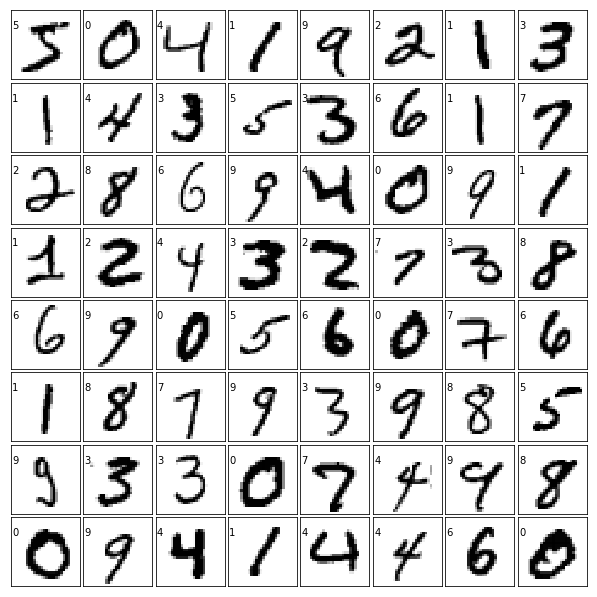

In [10]:
## plot the first 64 samples, and get a sense of the data
fig = plt.figure(figsize = (8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(64):
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
    ax.imshow(x_train[i],cmap=plt.cm.binary,interpolation='nearest')
    ax.text(0, 7, str(y_train[i]))

## Prepare data for ANN

In [11]:
# Flatten the images into 1D array
# Since the original shape a matrix with 28 rows and 28 columns, we can reshape this into a vector with (28x28) = 784 elements
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

# Convert the data type from int to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize the data by dividing the maximum value
x_train /= 255
x_test /= 255

In [12]:
num_classes = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [13]:
# See what the labeling look like now by printing out the first label
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

## Build ANN classifier  

Let's start to build the ANN model. We start by initializing a sequential model and add two hidden layers. 

In [14]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Notice that we adding and changing a few components of our MLP architecture:
    1. Dropout - Helps our neural network from overfitting the data by ignoring "dropping" some neuron updates during backpropogation
    2. activation = 'relu' - We are now using the rectified linear activation unit (ReLU) which is more computationally efficient than the sigmoid.
    3. activation = 'softmax' - 

In [15]:
# We compile the model by telling it what algorithms we are using for the backprop. 
# what metrics to mesure and so on. 
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

## Train the model

Let's train the model using a batch size 128 and 20 epochs. 

In [16]:
batch_size = 128
epochs = 20

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 11s 185us/step - loss: 0.2448 - acc: 0.9249 - val_loss: 0.1251 - val_acc: 0.9629
Epoch 2/20
60000/60000 [==============================] - 11s 178us/step - loss: 0.1016 - acc: 0.9688 - val_loss: 0.0788 - val_acc: 0.9769
Epoch 3/20
60000/60000 [==============================] - 12s 196us/step - loss: 0.0753 - acc: 0.9772 - val_loss: 0.0787 - val_acc: 0.9776
Epoch 4/20
60000/60000 [==============================] - 13s 216us/step - loss: 0.0594 - acc: 0.9816 - val_loss: 0.0787 - val_acc: 0.9801
Epoch 5/20
60000/60000 [==============================] - 13s 215us/step - loss: 0.0512 - acc: 0.9850 - val_loss: 0.0760 - val_acc: 0.9803
Epoch 6/20
60000/60000 [==============================] - 13s 222us/step - loss: 0.0441 - acc: 0.9867 - val_loss: 0.0753 - val_acc: 0.9808
Epoch 7/20
60000/60000 [==============================] - 13s 221us/step - loss: 0.0390 - acc: 0.9887 - val_loss: 0.

I will explain the options usually you need change or know briefly here:  
* batch_size - How many data samples we pass to the model at once
* epochs - How many iterations we are doing for all the data, we are using 20 here, which means we run the training 20 times on all the training data. 

## Test ANN classifier and evaluate  

After we trained the ANN classifier, we will test the performance of the classifier using the test data.

In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11516640678803032
Test accuracy: 0.9831


## Save the model for other use

In [14]:
model.save('my_model.h5')